In [2]:
from typing import TypeAlias
import math

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
np.random.seed(0)

In [4]:
Sample: TypeAlias = list[int | float]
Data: TypeAlias = list[Sample]

Target: TypeAlias = int | float
Targets: TypeAlias = list[Target]

Weights: TypeAlias = list[list[float]]

In [5]:
# Activation functions

from abc import ABC, abstractmethod


class ActivationBase(ABC):
    @abstractmethod
    def calc(self, x: Sample) -> list[float]:
        """Apply the activation function to an layer output"""
        pass

    @abstractmethod
    def derivative(self, x: Sample):
        pass

#######################################


class ReLU(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        return np.maximum(0, x)

    def derivative(self, x: Sample):
        return self.calc(x=x)


class Sigmoid(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: Sample):
        return self.calc(x) * (1 - self.calc(x))

In [6]:
# Loss functions

class LossBase(ABC):
    @abstractmethod
    def calc(self, x: Sample, y: Target) -> float:
        """Apply the loss function to an output layer"""
        pass


class MSELoss(LossBase):
    """For regression""" 
    def calc(self, x: Sample, y: Target) -> float:
        loss = (y - x) ** 2

        return np.mean(loss)


In [7]:
class Dataset:
    def __init__(self, data: Data, targets: Targets) -> None:
        self.data: Data = data
        self._len = len(data)
        self.targets: Targets = targets

    def __len__(self) -> int:
        return self._len

    def __getitem__(self, index) -> Sample:
        return self.data[index]

    def __iter__(self):
        return iter(self.data)


In [51]:
class Linear:
    def __init__(self, n_inputs: int, n_neurons: int, activation: ActivationBase = None) -> None:
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons

        self.weights = self._init_weights()
        self.bias = self._init_bias()
        self.output = []

        self.activation = activation

    def _init_weights(self) -> list[float]:
        weights = np.random.randn(self.n_inputs, self.n_neurons) * np.sqrt(2. / self.n_inputs)
        return weights

    def _init_bias(self) -> list[float]:
        return np.random.randn(1)[0]

    def forward(self, inputs) -> None:
        output = []
        for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                output.append(self.weights[i][j] * inputs[i])

        output = np.array(output)
        output += self.bias

        if self.activation:
            self.output = self.activation.calc(output)
        else:
            self.output = output

    def backward(self, delta: list[float]) -> list[float]:
        new_deltas = []
        for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                new_delta = self.weights[i][j] * delta[j]
                new_delta *= self.activation.derivative(self.output[i + j])
                new_deltas.append(new_delta)
        new_deltas = np.array(new_deltas)
        return new_deltas

    def update_weights(self, delta, learning_rate) -> None:
         for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                self.weights[i][j] += delta[i + j] * self.output[i + j] * learning_rate


Layers: TypeAlias = list[Linear]

In [45]:
class Model:
    def __init__(self, layers: Layers, loss: LossBase):
        self.layers = layers
        self._layers_len = len(layers)
        self.loss = loss

    def fit(self, dataset: Dataset, n_epoch: int = 1, learning_rate: float = 0.01, verbose: bool = True) -> list[float]:
        losses_by_epoch = []

        range_epoch = range(n_epoch)
        if verbose:
            range_epoch = tqdm(range_epoch, desc="epochs", position=0)

        for epoch in range_epoch:
            epoch_losses = []

            for i,sample in enumerate(dataset):
                if not isinstance(sample, list):
                    sample = [sample]

                sample = np.array(sample)


                # Forward pass
                self.layers[0].forward(inputs=sample) # input layer
                for j in range(1, self._layers_len):
                    self.layers[j].forward(inputs=self.layers[j-1].output)

                target = dataset.targets[i]

                # Calc loss
                output_error = self.calc_loss(target=target)
                epoch_losses.append(output_error)

                # Backward pass
                delta_list = []
                delta = np.array([output_error])
                delta_list.append(delta)
                for i in range(self._layers_len - 1, -1, -1):
                    delta = self.layers[i].backward(delta=delta_list[-1])
                    delta_list.append(delta)

                # Update weights
                delta_list = delta_list[::-1]
                for i in range(self._layers_len):
                   self.layers[i].update_weights(delta=delta_list[i], learning_rate=learning_rate)

            mean_loss = np.mean(epoch_losses)
            losses_by_epoch.append(mean_loss)

        return losses_by_epoch
    
    def predict(self, sample: Sample) -> list[float]:
        sample = np.array([sample])

        self.layers[0].forward(inputs=sample)
        for i in range(1, self._layers_len):
            self.layers[i].forward(inputs=self.layers[i-1].output)

        return np.mean(self.layers[-1].output)

    def calc_loss(self, target: Target) -> float:
        output_layer = self.layers[-1]
        output = output_layer.output

        loss = self.loss.calc(x=output, y=target)
        return loss


    def set_weights(self, weights: Weights) -> None:
        for w,layer in zip(weights, self.layers):
            layer.weights = w

    @property
    def weights(self) -> Weights:
        weights = [layer.weights for layer in self.layers]
        return weights

## Dataset

In [10]:
X = sorted(np.random.uniform(0, 10, 500))
y = [math.cos(x) for x in X]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)

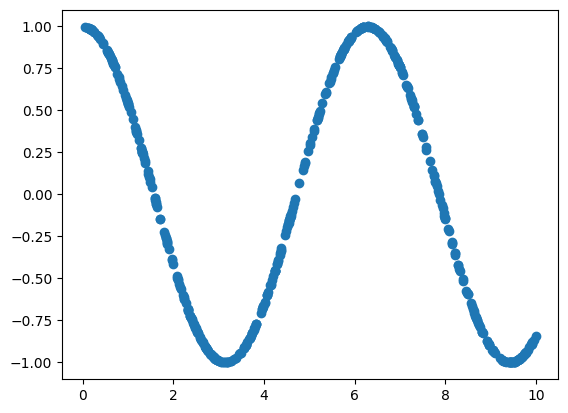

In [11]:
plt.plot(X, y, 'o')
plt.show()

In [87]:
train_dataset = Dataset(data=X_train, targets=y_train)

layers = [
    Linear(1,2, activation=Sigmoid()),
    Linear(2,4, activation=Sigmoid()),
    Linear(4,1, activation=Sigmoid()),
]

model = Model(layers=layers, loss=MSELoss())


losses = model.fit(dataset=train_dataset, n_epoch=100, learning_rate=0.001, verbose=1)

epochs: 100%|██████████| 100/100 [00:01<00:00, 67.36it/s]


In [88]:
losses

[0.905669218718462,
 0.9091345037591952,
 0.9128640648271777,
 0.9168806287172399,
 0.9212089354362084,
 0.9258758568235751,
 0.9309104904151414,
 0.9363442120289157,
 0.9422106643256979,
 0.9485456506540867,
 0.9553868936740381,
 0.9627736066499801,
 0.9707458124833002,
 0.9793433329420509,
 0.9886043609537287,
 0.9985635270932569,
 1.0092493849891726,
 1.020681279530947,
 1.0328656384274006,
 1.0457918519541565,
 1.0594280786827028,
 1.0737175173284041,
 1.0885758646422534,
 1.1038907472360682,
 1.1195237628578292,
 1.1353153208712623,
 1.1510917804997804,
 1.1666736866984486,
 1.1818835914764234,
 1.1965523711980075,
 1.2105240931337937,
 1.22366075756526,
 1.2358486375680369,
 1.247006615541299,
 1.2570938938280733,
 1.2661109624840696,
 1.2740860925739907,
 1.2810418087001927,
 1.2869301210043915,
 1.2914795251000137,
 1.2939525194155141,
 1.2932046341232735,
 1.2883930191451618,
 1.2801026136041316,
 1.2705409287692608,
 1.2617900493157503,
 1.254941812699965,
 1.2509967935516053

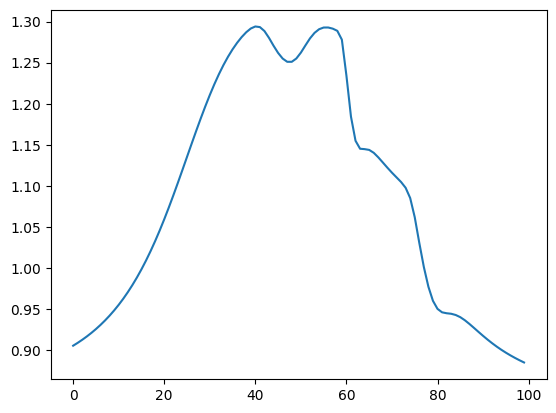

In [89]:
plt.plot(losses)
plt.show()

In [90]:
preds = []
for i in X_val:
    pred = model.predict(i)
    preds.append(pred)

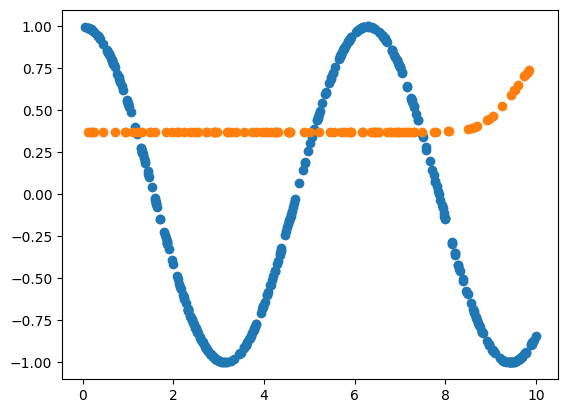

In [91]:
plt.plot(X_train, y_train, 'o')
plt.plot(X_val, preds, 'o')
plt.show()